In [1]:
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

%matplotlib inline
sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('./Datasets/train.csv')

In [3]:
import random

test_index_1 = random.sample(list(train[train.Class==1].index), int(15*train[train.Class==1].shape[0]/100))
test_index_0 = random.sample(list(train[train.Class==0].index), int(15*train[train.Class==0].shape[0]/100))

test = train.iloc[test_index_1+test_index_0]
train.drop(test_index_1+test_index_0, inplace=True)
train.reset_index(drop=True, inplace=True)

In [4]:
train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.00,-1.36,-0.07,2.54,1.38,-0.34,0.46,0.24,0.10,0.36,...,-0.02,0.28,-0.11,0.07,0.13,-0.19,0.13,-0.02,149.62,0
1,0.00,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,0.09,-0.26,...,-0.23,-0.64,0.10,-0.34,0.17,0.13,-0.01,0.01,2.69,0
2,1.00,-1.36,-1.34,1.77,0.38,-0.50,1.80,0.79,0.25,-1.51,...,0.25,0.77,0.91,-0.69,-0.33,-0.14,-0.06,-0.06,378.66,0
3,1.00,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,0.38,-1.39,...,-0.11,0.01,-0.19,-1.18,0.65,-0.22,0.06,0.06,123.50,0
4,2.00,-0.43,0.96,1.14,-0.17,0.42,-0.03,0.48,0.26,-0.57,...,-0.21,-0.56,-0.03,-0.37,-0.23,0.11,0.25,0.08,3.67,0


In [5]:
train.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

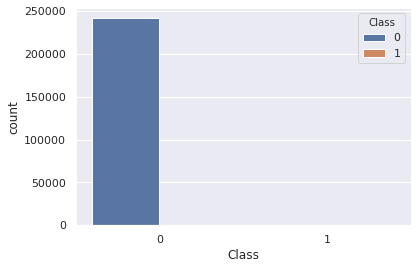

In [6]:
sns.countplot(x='Class', data=train, hue="Class")
plt.show()

In [7]:
print(f"Fraud instaces: {train[train['Class']==1].shape[0]}")
print(f"Non Fraud instaces: {train[train['Class']==0].shape[0]}")
print(f"Fraud percentage: {train[train['Class']==1].shape[0]/train.shape[0]}")
print(f"Non Fraud percentage: {train[train['Class']==0].shape[0]/train.shape[0]}")

Fraud instaces: 419
Non Fraud instaces: 241668
Fraud percentage: 0.001730782735132411
Non Fraud percentage: 0.9982692172648676


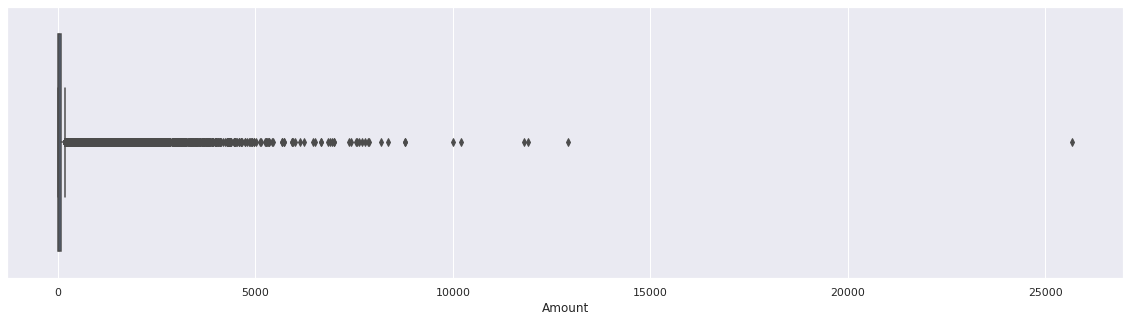

In [8]:
plt.figure(figsize=(20, 5))
sns.boxplot(x=train.Amount)

In [9]:
train = train[train['Amount']  <= 10000]
train.reset_index(drop=True, inplace=True)

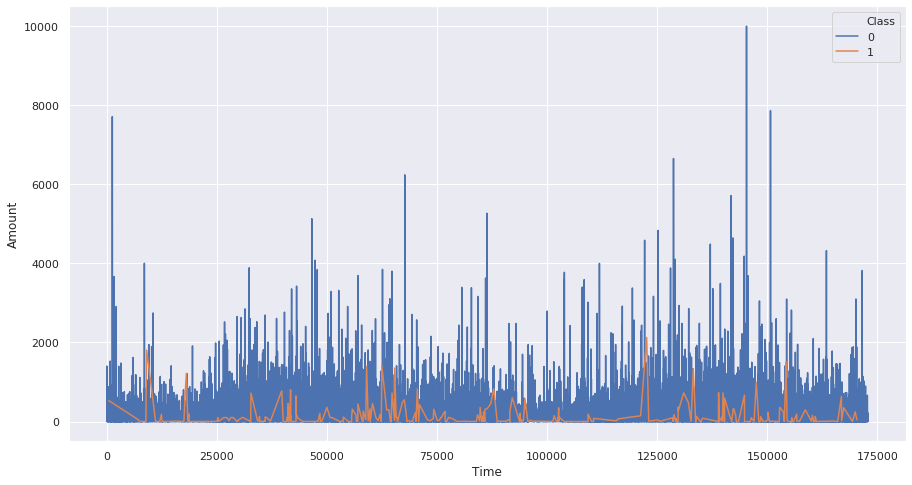

In [10]:
plt.figure(figsize=(15, 8))
sns.lineplot(x="Time", y="Amount", hue="Class", data=train, ci=None)
plt.show()

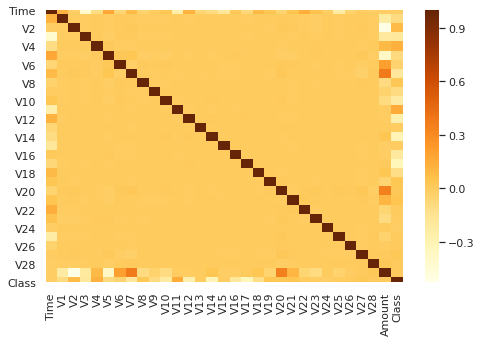

In [11]:
plt.figure(figsize=(8, 5))
sns.heatmap(data = train.corr(), cmap = "YlOrBr")

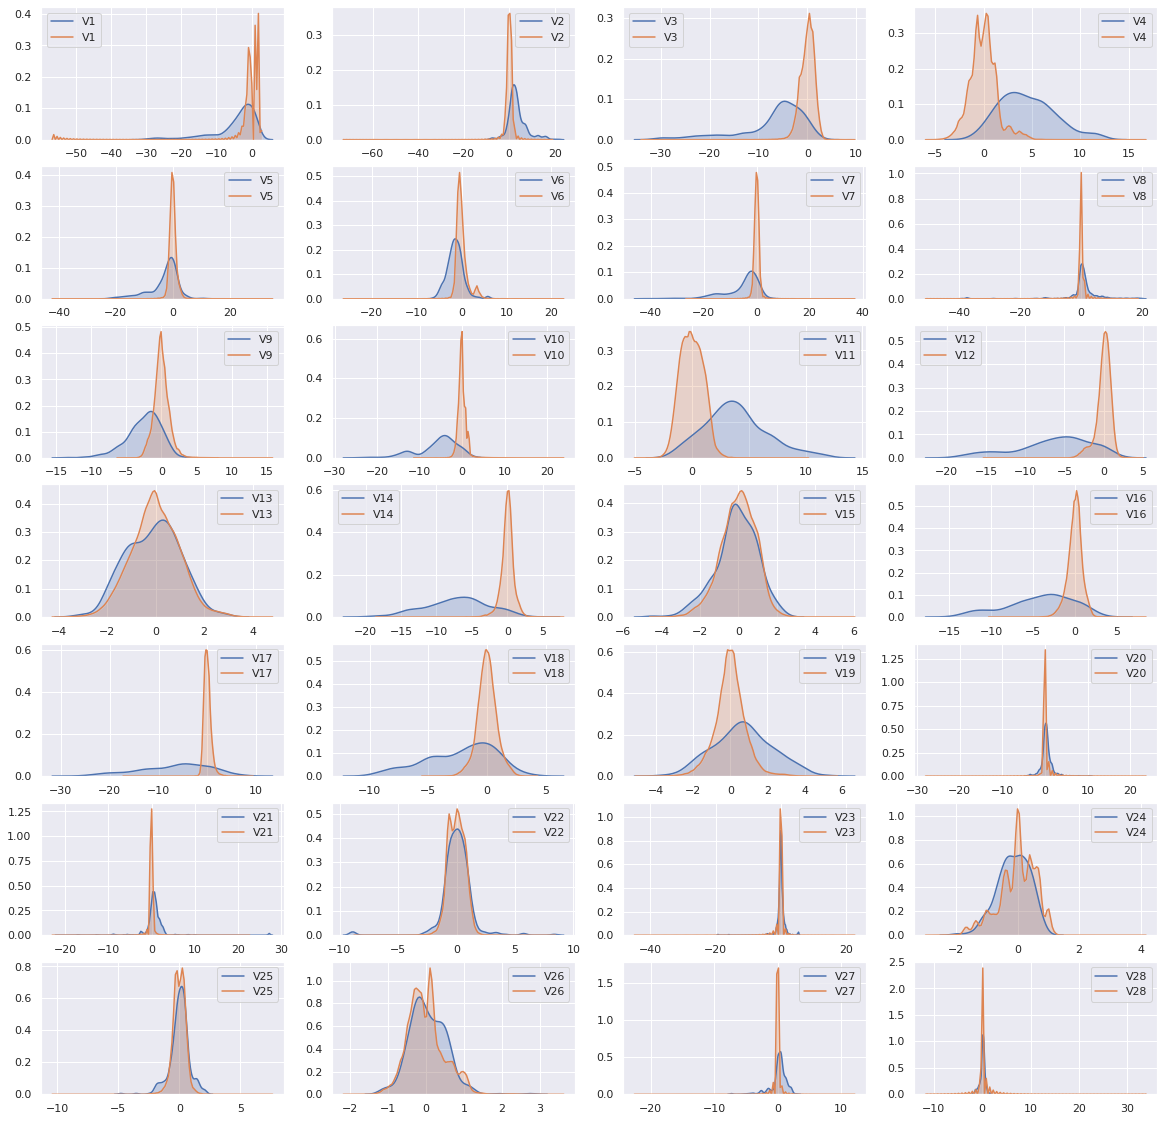

In [12]:
fig, ax = plt.subplots(7, 4, figsize=(20, 20))
for i in range(0, 28):
    sns.kdeplot(train[train['Class']==1][f'V{i+1}'], shade=True, ax=ax[int(i/4)][i%4])
    sns.kdeplot(train[train['Class']==0][f'V{i+1}'], shade=True, ax=ax[int(i/4)][i%4])
fig.show()

In [13]:
train.drop(['V13', 'V15', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28'], axis=1, inplace=True)
test.drop(['V13', 'V15', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28'], axis=1, inplace=True)

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(train.drop('Class', axis=1))

test_y = test.Class
test = test.drop('Class', axis=1)
test = scaler.transform(test)

class_0_train_1000 = train[train.Class==0].sample(1000)

In [15]:
from imblearn.over_sampling import SMOTE

#Sample
sampled_data = class_0_train_1000
sampled_data = pd.concat([sampled_data, train[train.Class==1]], ignore_index=True)
sampled_data = sampled_data.sample(frac=1).reset_index(drop=True)

#Over sample
oversampled_data, oversampled_y = SMOTE(k_neighbors=7).fit_resample(sampled_data.drop('Class', axis=1), sampled_data.Class)
oversampled_data['Class'] =  oversampled_y
oversampled_data_std = scaler.transform(oversampled_data.drop('Class', axis=1))
oversampled_data_std = pd.DataFrame(oversampled_data_std)
oversampled_data_std['Class'] = oversampled_data.Class
oversampled_data_std.columns = oversampled_data.columns

#Under sample
undersampled_data = class_0_train_1000
undersampled_data = pd.concat([undersampled_data, train[train.Class==1]], ignore_index=True)
undersampled_data = undersampled_data.sample(frac=1).reset_index(drop=True)
undersampled_data_std = scaler.transform(undersampled_data.drop('Class', axis=1))
undersampled_data_std = pd.DataFrame(undersampled_data_std)
undersampled_data_std['Class'] = undersampled_data.Class
undersampled_data_std.columns = undersampled_data.columns

Using TensorFlow backend.


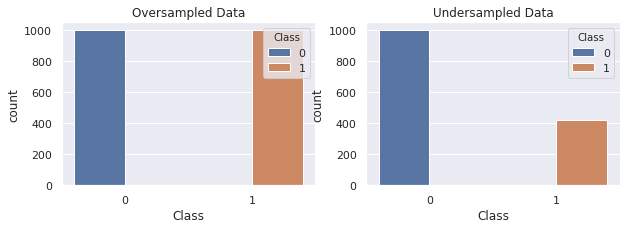

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
sns.countplot(x='Class', data=oversampled_data, hue="Class", ax=ax[0])
ax[0].title.set_text(f'Oversampled Data')
sns.countplot(x='Class', data=undersampled_data, hue="Class", ax=ax[1])
ax[1].title.set_text(f'Undersampled Data')

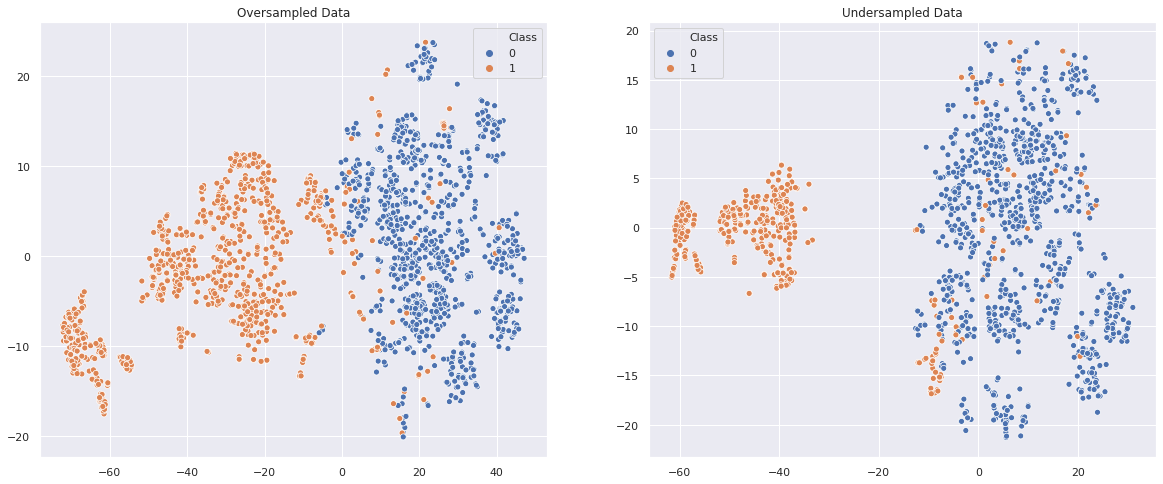

In [17]:
from sklearn.manifold import TSNE

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
tsne = TSNE(n_components=2, random_state=42, perplexity=75).fit_transform(oversampled_data_std)
sns.scatterplot(x=tsne[:,0], y=tsne[:,1], hue=oversampled_data_std.Class, ax=ax[0])
ax[0].title.set_text(f'Oversampled Data')

tsne = TSNE(n_components=2, random_state=42, perplexity=75).fit_transform(undersampled_data_std)
sns.scatterplot(x=tsne[:,0], y=tsne[:,1], hue=undersampled_data_std.Class, ax=ax[1])
ax[1].title.set_text(f'Undersampled Data')

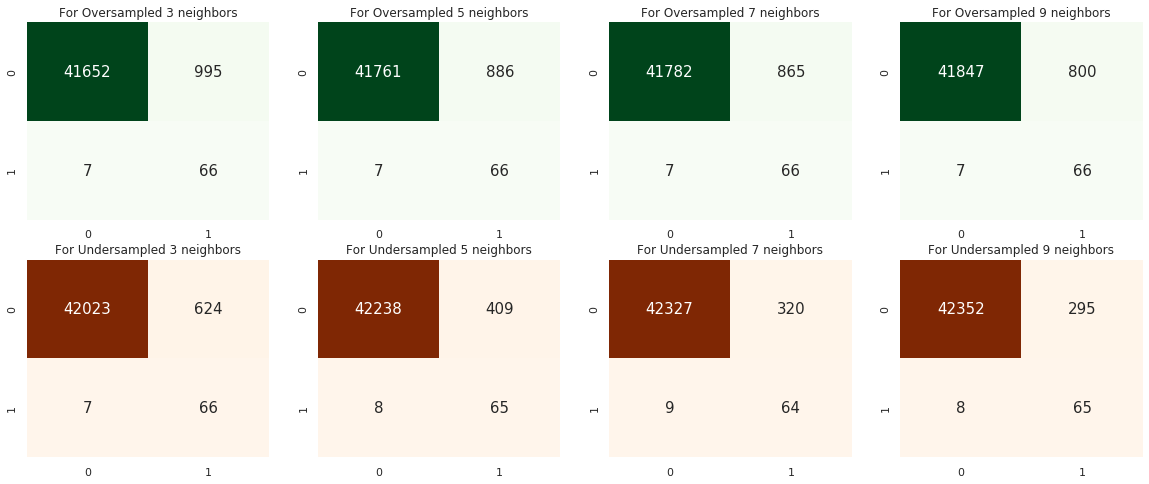

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(2, 4, figsize=(20, 8))
i = 0
for n in range(3, 10, 2):
    knn = KNeighborsClassifier(n).fit(oversampled_data_std.drop(['Class'], axis=1).values, oversampled_data_std.Class.values)
    y_pred = knn.predict(test)    
    sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[0][i], cmap="Greens", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
    bottom, top = ax[0][i].get_ylim()
    ax[0][i].set_ylim(bottom + 0.5, top - 0.5)
    ax[0][i].title.set_text(f'For Oversampled {n} neighbors')
    i+=1
    
i = 0
for n in range(3, 10, 2):
    knn = KNeighborsClassifier(n).fit(undersampled_data_std.drop(['Class'], axis=1).values, undersampled_data_std.Class.values)
    y_pred = knn.predict(test)    
    sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[1][i], cmap="Oranges", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
    bottom, top = ax[1][i].get_ylim()
    ax[1][i].set_ylim(bottom + 0.5, top - 0.5)
    ax[1][i].title.set_text(f'For Undersampled {n} neighbors')
    i+=1

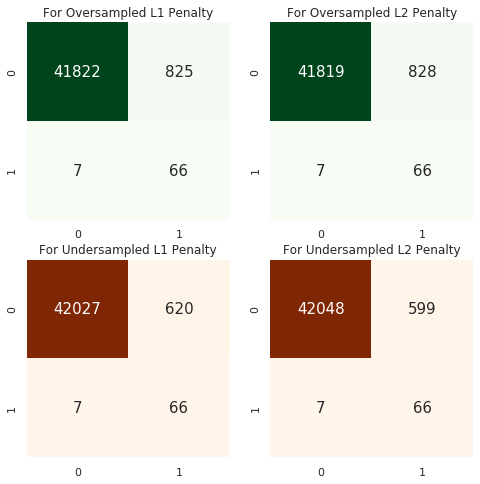

In [19]:
from sklearn.linear_model import LogisticRegression

fig, ax = plt.subplots(2, 2, figsize=(8, 8))

lg = LogisticRegression(penalty='l1', solver='liblinear')\
    .fit(oversampled_data_std.drop(['Class'], axis=1).values, oversampled_data_std.Class.values)
y_pred = lg.predict(test)
sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[0][0], cmap="Greens", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
bottom, top = ax[0][0].get_ylim()
ax[0][0].set_ylim(bottom + 0.5, top - 0.5)
ax[0][0].title.set_text(f'For Oversampled L1 Penalty')

lg = LogisticRegression(penalty='l2', solver='liblinear')\
    .fit(oversampled_data_std.drop(['Class'], axis=1).values, oversampled_data_std.Class.values)
y_pred = lg.predict(test)
sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[0][1], cmap="Greens", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
bottom, top = ax[0][1].get_ylim()
ax[0][1].set_ylim(bottom + 0.5, top - 0.5)
ax[0][1].title.set_text(f'For Oversampled L2 Penalty')
                                                                
lg = LogisticRegression(penalty='l1', solver='liblinear')\
    .fit(undersampled_data_std.drop(['Class'], axis=1).values, undersampled_data_std.Class.values)
y_pred = lg.predict(test)
sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[1][0], cmap="Oranges", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
bottom, top = ax[1][0].get_ylim()
ax[1][0].set_ylim(bottom + 0.5, top - 0.5)
ax[1][0].title.set_text(f'For Undersampled L1 Penalty')

lg = LogisticRegression(penalty='l2', solver='liblinear')\
    .fit(undersampled_data_std.drop(['Class'], axis=1).values, undersampled_data_std.Class.values)
y_pred = lg.predict(test)
sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[1][1], cmap="Oranges", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
bottom, top = ax[1][1].get_ylim()
ax[1][1].set_ylim(bottom + 0.5, top - 0.5)
ax[1][1].title.set_text(f'For Undersampled L2 Penalty')

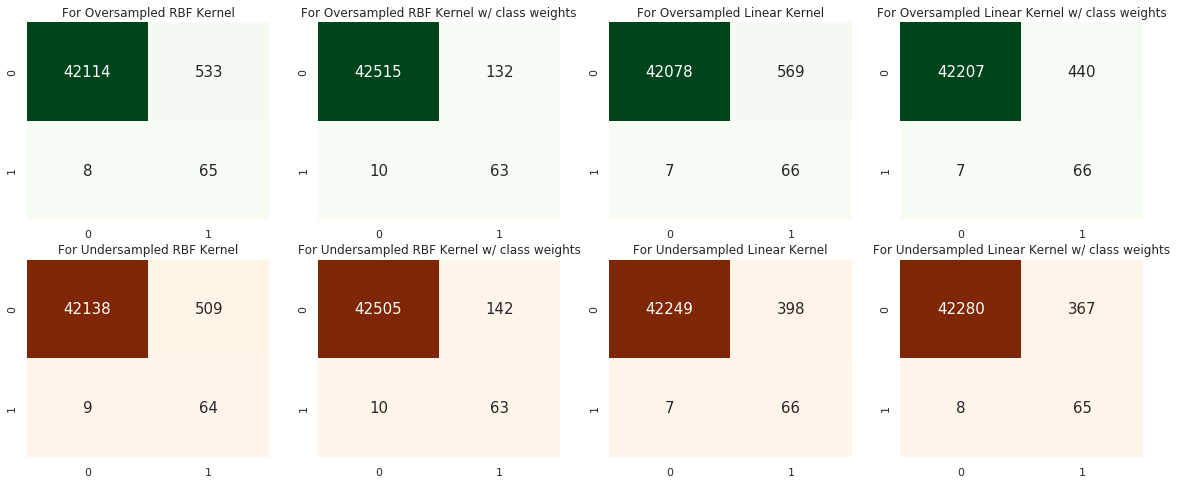

In [20]:
from sklearn.svm import SVC

fig, ax = plt.subplots(2, 4, figsize=(20, 8))


svm = SVC(kernel='rbf')\
    .fit(oversampled_data_std.drop(['Class'], axis=1).values, oversampled_data_std.Class.values)
y_pred = svm.predict(test)
sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[0][0], cmap="Greens", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
bottom, top = ax[0][0].get_ylim()
ax[0][0].set_ylim(bottom + 0.5, top - 0.5)
ax[0][0].title.set_text(f'For Oversampled RBF Kernel')

svm = SVC(kernel='rbf', class_weight={0:0.70, 1:0.30})\
    .fit(oversampled_data_std.drop(['Class'], axis=1).values, oversampled_data_std.Class.values)
y_pred = svm.predict(test)
sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[0][1], cmap="Greens", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
bottom, top = ax[0][1].get_ylim()
ax[0][1].set_ylim(bottom + 0.5, top - 0.5)
ax[0][1].title.set_text(f'For Oversampled RBF Kernel w/ class weights')

svm = SVC(kernel='linear')\
    .fit(oversampled_data_std.drop(['Class'], axis=1).values, oversampled_data_std.Class.values)
y_pred = svm.predict(test)
sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[0][2], cmap="Greens", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
bottom, top = ax[0][2].get_ylim()
ax[0][2].set_ylim(bottom + 0.5, top - 0.5)
ax[0][2].title.set_text(f'For Oversampled Linear Kernel')

svm = SVC(kernel='linear', class_weight={0:0.60, 1:0.40})\
    .fit(oversampled_data_std.drop(['Class'], axis=1).values, oversampled_data_std.Class.values)
y_pred = svm.predict(test)
sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[0][3], cmap="Greens", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
bottom, top = ax[0][3].get_ylim()
ax[0][3].set_ylim(bottom + 0.5, top - 0.5)
ax[0][3].title.set_text(f'For Oversampled Linear Kernel w/ class weights')

svm = SVC(kernel='rbf')\
    .fit(undersampled_data_std.drop(['Class'], axis=1).values, undersampled_data_std.Class.values)
y_pred = svm.predict(test)
sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[1][0], cmap="Oranges", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
bottom, top = ax[1][0].get_ylim()
ax[1][0].set_ylim(bottom + 0.5, top - 0.5)
ax[1][0].title.set_text(f'For Undersampled RBF Kernel')

svm = SVC(kernel='rbf', class_weight={0:0.70, 1:0.30})\
    .fit(undersampled_data_std.drop(['Class'], axis=1).values, undersampled_data_std.Class.values)
y_pred = svm.predict(test)
sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[1][1], cmap="Oranges", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
bottom, top = ax[1][1].get_ylim()
ax[1][1].set_ylim(bottom + 0.5, top - 0.5)
ax[1][1].title.set_text(f'For Undersampled RBF Kernel w/ class weights')

svm = SVC(kernel='linear')\
    .fit(undersampled_data_std.drop(['Class'], axis=1).values, undersampled_data_std.Class.values)
y_pred = svm.predict(test)
sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[1][2], cmap="Oranges", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
bottom, top = ax[1][2].get_ylim()
ax[1][2].set_ylim(bottom + 0.5, top - 0.5)
ax[1][2].title.set_text(f'For Undersampled Linear Kernel')

svm = SVC(kernel='linear', class_weight={0:0.60, 1:0.40})\
    .fit(undersampled_data_std.drop(['Class'], axis=1).values, undersampled_data_std.Class.values)
y_pred = svm.predict(test)
sns.heatmap(confusion_matrix(test_y, y_pred), annot=True, ax=ax[1][3], cmap="Oranges", cbar = False, fmt='.0f', annot_kws={"fontsize":15})
bottom, top = ax[1][3].get_ylim()
ax[1][3].set_ylim(bottom + 0.5, top - 0.5)
ax[1][3].title.set_text(f'For Undersampled Linear Kernel w/ class weights')

In [21]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import Adam

val_index_1 = random.sample(list(undersampled_data_std[undersampled_data_std.Class==1].index), 
                                int(15*undersampled_data_std[undersampled_data_std.Class==1].shape[0]/100))
val_index_0 = random.sample(list(undersampled_data_std[undersampled_data_std.Class==0].index), 
                                int(15*undersampled_data_std[undersampled_data_std.Class==0].shape[0]/100))

val = undersampled_data_std.iloc[val_index_0+val_index_1]
val_X = val.drop('Class', axis=1)
val_y = val.Class
data_X = undersampled_data_std.drop(val_index_1+val_index_0)

undersampled_data_X = data_X.drop('Class', axis=1)
undersampled_data_y = data_X.Class
n_inputs = undersampled_data_X.shape[1]

undersample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

undersample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
undersample_model.fit(undersampled_data_X.values, undersampled_data_y.values, 
                      validation_data=(val_X.values, val_y.values), batch_size=16, 
                      epochs=10, shuffle=True, verbose=2)

Train on 1207 samples, validate on 212 samples
Epoch 1/10
 - 1s - loss: 0.4230 - accuracy: 0.8542 - val_loss: 0.2864 - val_accuracy: 0.9387
Epoch 2/10
 - 0s - loss: 0.1997 - accuracy: 0.9528 - val_loss: 0.1975 - val_accuracy: 0.9434
Epoch 3/10
 - 0s - loss: 0.1428 - accuracy: 0.9586 - val_loss: 0.1734 - val_accuracy: 0.9481
Epoch 4/10
 - 0s - loss: 0.1178 - accuracy: 0.9602 - val_loss: 0.1648 - val_accuracy: 0.9528
Epoch 5/10
 - 0s - loss: 0.1040 - accuracy: 0.9652 - val_loss: 0.1668 - val_accuracy: 0.9528
Epoch 6/10
 - 0s - loss: 0.0953 - accuracy: 0.9669 - val_loss: 0.1702 - val_accuracy: 0.9528
Epoch 7/10
 - 0s - loss: 0.0891 - accuracy: 0.9685 - val_loss: 0.1727 - val_accuracy: 0.9481
Epoch 8/10
 - 0s - loss: 0.0851 - accuracy: 0.9727 - val_loss: 0.1767 - val_accuracy: 0.9481
Epoch 9/10
 - 0s - loss: 0.0804 - accuracy: 0.9727 - val_loss: 0.1790 - val_accuracy: 0.9481
Epoch 10/10
 - 0s - loss: 0.0781 - accuracy: 0.9743 - val_loss: 0.1807 - val_accuracy: 0.9481


In [22]:
val_index_1 = random.sample(list(oversampled_data_std[oversampled_data_std.Class==1].index), int(15*oversampled_data_std[oversampled_data_std.Class==1].shape[0]/100))
val_index_0 = random.sample(list(oversampled_data_std[oversampled_data_std.Class==0].index), int(15*oversampled_data_std[oversampled_data_std.Class==0].shape[0]/100))

val = oversampled_data_std.iloc[val_index_0+val_index_1]
val_X = val.drop('Class', axis=1)
val_y = val.Class
data_X = oversampled_data_std.drop(val_index_1+val_index_0)

oversampled_data_X = data_X.drop('Class', axis=1)
oversampled_data_y = data_X.Class
n_inputs = oversampled_data_X.shape[1]

oversample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

oversample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
oversample_model.fit(oversampled_data_X.values, oversampled_data_y.values, 
                      validation_data=(val_X.values, val_y.values), batch_size=16, 
                      epochs=10, shuffle=True, verbose=2)

Train on 1700 samples, validate on 300 samples
Epoch 1/10
 - 1s - loss: 0.4727 - accuracy: 0.8000 - val_loss: 0.2080 - val_accuracy: 0.9500
Epoch 2/10
 - 0s - loss: 0.1696 - accuracy: 0.9465 - val_loss: 0.1268 - val_accuracy: 0.9600
Epoch 3/10
 - 0s - loss: 0.1169 - accuracy: 0.9618 - val_loss: 0.1081 - val_accuracy: 0.9633
Epoch 4/10
 - 0s - loss: 0.0974 - accuracy: 0.9700 - val_loss: 0.1017 - val_accuracy: 0.9667
Epoch 5/10
 - 0s - loss: 0.0851 - accuracy: 0.9741 - val_loss: 0.1006 - val_accuracy: 0.9600
Epoch 6/10
 - 0s - loss: 0.0790 - accuracy: 0.9741 - val_loss: 0.0986 - val_accuracy: 0.9600
Epoch 7/10
 - 0s - loss: 0.0732 - accuracy: 0.9765 - val_loss: 0.0969 - val_accuracy: 0.9667
Epoch 8/10
 - 0s - loss: 0.0680 - accuracy: 0.9794 - val_loss: 0.0975 - val_accuracy: 0.9633
Epoch 9/10
 - 0s - loss: 0.0638 - accuracy: 0.9806 - val_loss: 0.0985 - val_accuracy: 0.9667
Epoch 10/10
 - 0s - loss: 0.0599 - accuracy: 0.9818 - val_loss: 0.0941 - val_accuracy: 0.9633


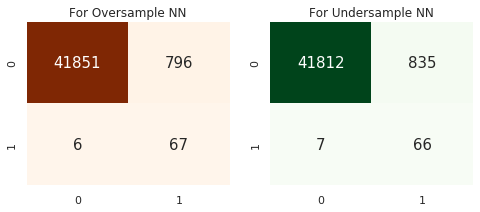

In [23]:
oversample_predictions = oversample_model.predict(test, batch_size=200, verbose=0)
oversample_pred =  pd.DataFrame(oversample_predictions[:,0] < oversample_predictions[:,1])
oversample_pred.columns = ['Class']
oversample_pred.Class.apply(lambda x : 1 if x else 0)

undersample_predictions = undersample_model.predict(test, batch_size=200, verbose=0)
undersample_pred =  pd.DataFrame(undersample_predictions[:,0] < undersample_predictions[:,1])
undersample_pred.columns = ['Class']
undersample_pred.Class.apply(lambda x : 1 if x else 0)

fig, ax = plt.subplots(1, 2, figsize=(8,3))

sns.heatmap(confusion_matrix(test_y, oversample_pred), 
            annot=True, cmap="Oranges", 
            cbar = False, fmt='.0f', annot_kws={"fontsize":15}, ax=ax[0])
bottom, top = ax[0].get_ylim()
ax[0].set_ylim(bottom + 0.5, top - 0.5)
ax[0].title.set_text(f'For Oversample NN')

sns.heatmap(confusion_matrix(test_y, undersample_pred), 
            annot=True, cmap="Greens", 
            cbar = False, fmt='.0f', annot_kws={"fontsize":15}, ax=ax[1])
bottom, top = ax[1].get_ylim()
ax[1].set_ylim(bottom + 0.5, top - 0.5)
ax[1].title.set_text(f'For Undersample NN')

In [24]:
train_std = scaler.transform(train.drop('Class', axis=1))
train_std = pd.DataFrame(train_std)
train_std['Class'] = train.Class
train_std.columns = train.columns

val_index_1 = random.sample(list(train_std[train_std.Class==1].index), int(15*train_std[train_std.Class==1].shape[0]/100))
val_index_0 = random.sample(list(train_std[train_std.Class==0].index), int(15*train_std[train_std.Class==0].shape[0]/100))

val = train_std.iloc[val_index_0+val_index_1]
val_X = val.drop('Class', axis=1)
val_y = val.Class
data_X = train_std.drop(val_index_1+val_index_0)

train_X = data_X.drop('Class', axis=1)
train_y = data_X.Class
n_inputs = train_X.shape[1]

train_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

In [25]:
import pickle

for i, learning in enumerate([0.001, 0.005, 0.01]):
    for j, weight in enumerate([50., 100.]):
        for k, epoch in enumerate([5, 10, 20]):
            train_model.compile(Adam(lr=learning), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
            train_model.fit(train_X, train_y, 
                            validation_data=(val_X.values, val_y.values), batch_size=16, 
                            epochs=epoch, shuffle=True, verbose=2, class_weight = {0: 1., 1: weight})

            file = open(f"model_eta-{learning}_w-{weight}_e-{epoch}.pickle", "wb") 
            pickle.dump(train_model, file)
            file.close()

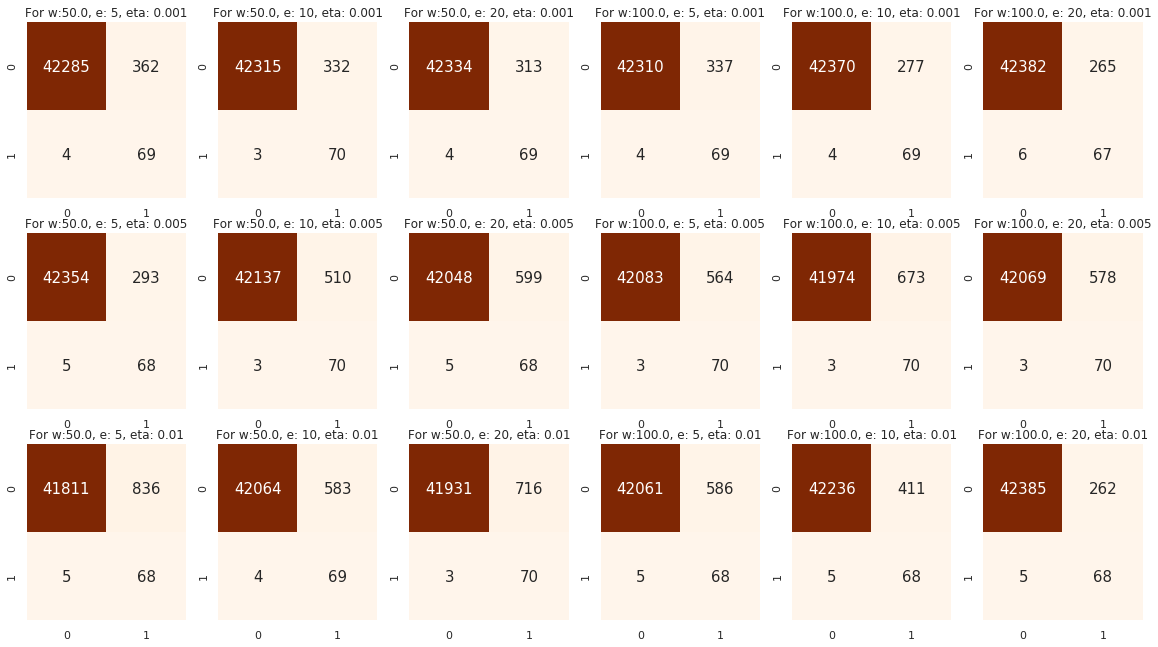

In [26]:
import pickle
fig, ax = plt.subplots(3, 6, figsize=(20, 11))

for i, learning in enumerate([0.001, 0.005, 0.01]):
    for j, weight in enumerate([50., 100.]):
        for k, epoch in enumerate([5, 10, 20]):
            file = open(f"model_eta-{learning}_w-{weight}_e-{epoch}.pickle", "rb") 
            train_model = pickle.load(file)
            file.close()
            train_predictions = train_model.predict(test, batch_size=200, verbose=0)
            train_pred =  pd.DataFrame(train_predictions[:,0] < train_predictions[:,1])
            train_pred.columns = ['Class']
            train_pred.Class.apply(lambda x : 1 if x else 0)

            sns.heatmap(confusion_matrix(test_y, train_pred), 
                        annot=True, cmap="Oranges", 
                        cbar = False, fmt='.0f', annot_kws={"fontsize":15}, ax=ax[i][j*3+k])
            bottom, top = ax[i][j*3+k].get_ylim()
            ax[i][j*3+k].set_ylim(bottom + 0.5, top - 0.5)
            ax[i][j*3+k].title.set_text(f'For w:{weight}, e: {epoch}, eta: {learning}')